# Dual Class Arbitrage Identifier
This notebook contains the code to identify stocks that have dual listings within the S&P 500 Index and arbitrage opportunities when trading these dual-listed stocks.

## 1. Importing Libraries

In [1]:
import yfinance as yfin
import pandas as pd
from urllib import request
import ssl
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import seaborn as sb
import matplotlib.pyplot as plt

## 2. Getting Dual-Listed Stocks

In [2]:
# get the list of tickers of stocks listed under the S&P 500 index

url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
context = ssl._create_unverified_context()
response = request.urlopen(url, context=context)
html = response.read()

sp500 = pd.read_html(html)[0]
print(sp500.head())

  Symbol     Security             GICS Sector               GICS Sub-Industry   
0    MMM           3M             Industrials        Industrial Conglomerates  \
1    AOS  A. O. Smith             Industrials               Building Products   
2    ABT       Abbott             Health Care           Health Care Equipment   
3   ABBV       AbbVie             Health Care                 Pharmaceuticals   
4    ACN    Accenture  Information Technology  IT Consulting & Other Services   

     Headquarters Location  Date added      CIK      Founded  
0    Saint Paul, Minnesota  1957-03-04    66740         1902  
1     Milwaukee, Wisconsin  2017-07-26    91142         1916  
2  North Chicago, Illinois  1957-03-04     1800         1888  
3  North Chicago, Illinois  2012-12-31  1551152  2013 (1888)  
4          Dublin, Ireland  2011-07-06  1467373         1989  


In [3]:
# splitting the 'Security' column to exclude the stock classes

sp500[['Security', 'Class']] = sp500['Security'].str.split(' \(Class ', expand = True)

In [4]:
# filtering out securities (companies) that are mentioned more than once

dual_listings = sp500[sp500.duplicated('Security', keep = False) == True]
dual_listings

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,Class
22,GOOGL,Alphabet Inc.,Communication Services,Interactive Media & Services,"Mountain View, California",2014-04-03,1652044,1998,A)
23,GOOG,Alphabet Inc.,Communication Services,Interactive Media & Services,"Mountain View, California",2006-04-03,1652044,1998,C)
208,FOXA,Fox Corporation,Communication Services,Movies & Entertainment,"New York City, New York",2013-07-01,1754301,2019,A)
209,FOX,Fox Corporation,Communication Services,Movies & Entertainment,"New York City, New York",2015-09-18,1754301,2019,B)
337,NWSA,News Corp,Communication Services,Publishing,"New York City, New York",2013-08-01,1564708,2013 (1980),A)
338,NWS,News Corp,Communication Services,Publishing,"New York City, New York",2015-09-18,1564708,2013 (1980),B)


We have three (3) dual-listed stocks in the S&P 500 index - Alphabet Inc. (GOOG, GOOGL), Fox Corporation (FOX, FOXA) and News Corp (NWS, NWSA).

## 3. Defining Functions

In [5]:
# function to get today's date

def today():
    today = date.today()
    today = today.strftime("%Y-%m-%d")
    return today

In [6]:
# function to get the date one week ago

def week_delta():
    last_week = datetime.now() - relativedelta(weeks = 1)
    last_week = last_week.strftime("%Y-%m-%d")
    return last_week

In [7]:
# function to get the date one day ago

def yday():
    yesterday = datetime.now() - relativedelta(days = 1)
    yesterday = yesterday.strftime("%Y-%m-%d")
    return yesterday

In [8]:
# function to create a dual-class arbitrage index from historical data, based on the adjusted closing prices

def dcai(classA, classB):
    df = pd.merge(classA, classB, left_index = True, right_index = True)
    return df[['Close_x', 'Close_y']]

## 4. Getting Data From Yahoo Finance for the Last One Day

In [9]:
googl = yfin.Ticker('googl')
goog = yfin.Ticker('goog')
foxa = yfin.Ticker('foxa')
fox = yfin.Ticker('fox')
nwsa = yfin.Ticker('nwsa')
nws = yfin.Ticker('nws')

In [10]:
# getting historical data with one minute intervals for the last one week

now = today()
oneday = yday()

googl_historical = googl.history(start = oneday, end = now, interval = "1m")
googl_historical

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-07-17 09:30:00-04:00,125.940002,126.500000,125.610001,126.040802,1169242,0.0,0.0
2023-07-17 09:31:00-04:00,126.040001,126.190002,125.639999,125.669998,168345,0.0,0.0
2023-07-17 09:32:00-04:00,125.650002,126.000000,125.559998,125.785004,104793,0.0,0.0
2023-07-17 09:33:00-04:00,125.809998,126.250000,125.760002,126.080002,123532,0.0,0.0
2023-07-17 09:34:00-04:00,126.070000,126.160004,125.959999,126.120003,114248,0.0,0.0
...,...,...,...,...,...,...,...
2023-07-17 15:55:00-04:00,124.750000,124.769997,124.665001,124.675003,160823,0.0,0.0
2023-07-17 15:56:00-04:00,124.680000,124.754997,124.680000,124.750000,160498,0.0,0.0
2023-07-17 15:57:00-04:00,124.749001,124.750000,124.669998,124.695000,173276,0.0,0.0


In [11]:
# repeat this for the other stocks
goog_historical = goog.history(start = oneday, end = now, interval = "1m")
foxa_historical = foxa.history(start = oneday, end = now, interval = "1m")
fox_historical = fox.history(start = oneday, end = now, interval = "1m")
nwsa_historical = nwsa.history(start = oneday, end = now, interval = "1m")
nws_historical = nws.history(start = oneday, end = now, interval = "1m")

## 5. Calculating Arbitrage Spreads

In [12]:
alphabet = dcai(goog_historical, googl_historical)
alphabet.rename(columns={'Close_x': 'Close_GOOG', 'Close_y': 'Close_GOOGL'}, inplace=True) # rename columns
alphabet['diff'] = alphabet['Close_GOOG'] - alphabet['Close_GOOGL']
alphabet.index = pd.DatetimeIndex(alphabet.index)
alphabet.index = alphabet.index.time
alphabet.index = alphabet.index.map(str)
alphabet

,Close_GOOG,Close_GOOGL,diff
09:30:00,126.250000,126.040802,0.209198
09:31:00,125.919998,125.669998,0.250000
09:32:00,126.000000,125.785004,0.214996
09:33:00,126.269997,126.080002,0.189995
09:34:00,126.300003,126.120003,0.180000
...,...,...,...
15:55:00,125.070000,124.675003,0.394997
15:56:00,125.128799,124.750000,0.378799
15:57:00,125.080002,124.695000,0.385002
15:58:00,125.019997,124.629997,0.389999


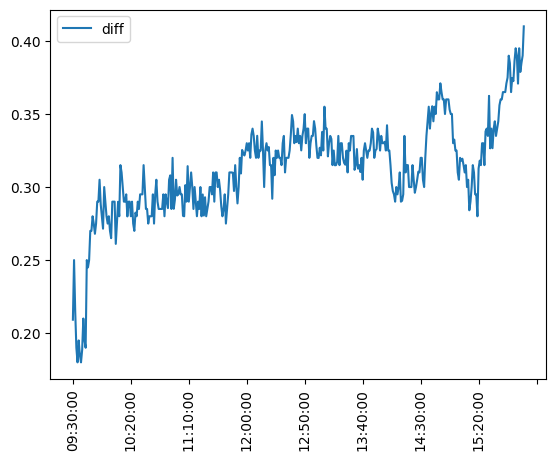

In [13]:
alphabet.plot(y = 'diff', rot = 90);

A trader can long 'GOOGL' stock and short 'GOOG' stock when the spread is positive and do the opposite when the spread is negative in order to gain a profit. Basically, one must long the stock that is trading at a lower price (buying low) and short the stock that is trading at a higher price (sell high).

In [14]:
# repeat for Fox Corporation

foxcorp = dcai(foxa_historical, fox_historical)
foxcorp.rename(columns={'Close_x': 'Close_FOXA', 'Close_y': 'Close_FOX'}, inplace=True) # rename columns
foxcorp['diff'] = foxcorp['Close_FOXA'] - foxcorp['Close_FOX']
foxcorp.index = pd.DatetimeIndex(foxcorp.index)
foxcorp.index = foxcorp.index.time
foxcorp.index = foxcorp.index.map(str)
foxcorp

,Close_FOXA,Close_FOX,diff
09:30:00,33.099998,31.070000,2.029999
09:31:00,33.150002,31.100000,2.050001
09:32:00,33.200001,31.110001,2.090000
09:33:00,33.180000,31.139999,2.040001
09:34:00,33.139999,31.070000,2.070000
...,...,...,...
15:55:00,33.446999,31.355000,2.091999
15:56:00,33.435001,31.350000,2.085001
15:57:00,33.435001,31.360001,2.075001
15:58:00,33.424999,31.360001,2.064999


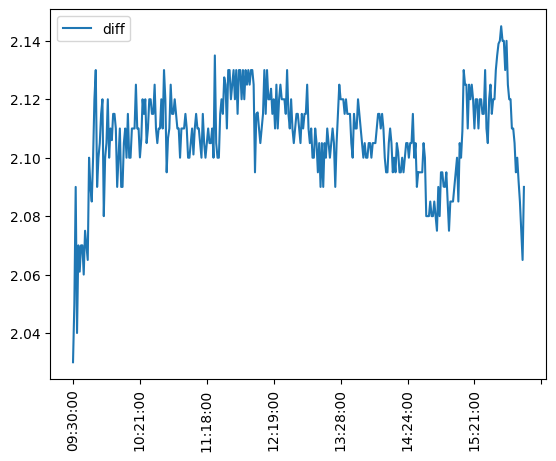

In [15]:
foxcorp.plot(y = 'diff', rot = 90);

A trader can long 'FOX' stock and short 'FOXA' stock when the spread is positive and do the opposite when the spread is negative in order to gain a profit.

In [16]:
# repeat for News Corp

nwscorp = dcai(nws_historical, nwsa_historical)
nwscorp.rename(columns={'Close_x': 'Close_NWS', 'Close_y': 'Close_NWSA'}, inplace=True) # rename columns
nwscorp['diff'] = nwscorp['Close_NWS'] - nwscorp['Close_NWSA']
nwscorp.index = pd.DatetimeIndex(nwscorp.index)
nwscorp.index = nwscorp.index.time
nwscorp.index = nwscorp.index.map(str)
nwscorp

,Close_NWS,Close_NWSA,diff
09:30:00,20.424999,20.209999,0.215000
09:31:00,20.379999,20.160000,0.219999
09:32:00,20.400000,20.170000,0.230000
09:33:00,20.410000,20.190001,0.219999
09:34:00,20.389999,20.165001,0.224998
...,...,...,...
15:55:00,20.635000,20.405001,0.230000
15:56:00,20.639999,20.400000,0.240000
15:57:00,20.650000,20.405001,0.244999
15:58:00,20.629999,20.405001,0.224998


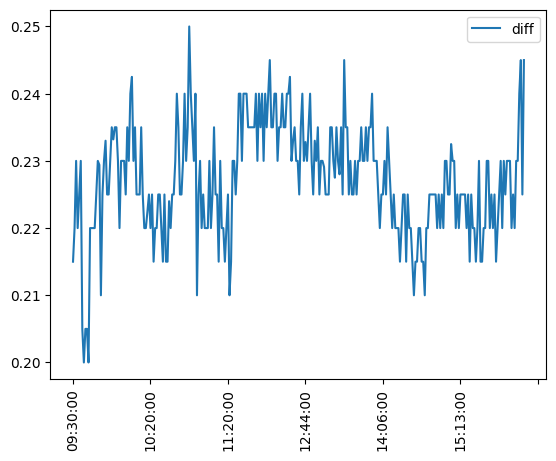

In [19]:
nwscorp.plot(y = 'diff', rot = 90);

A trader can long 'NWSA' stock and short 'NWS' stock when the spread is positive and do the opposite when the spread is negative in order to gain a profit.

### Plotting Arbitrage Spreads for the Last Ten Minutes

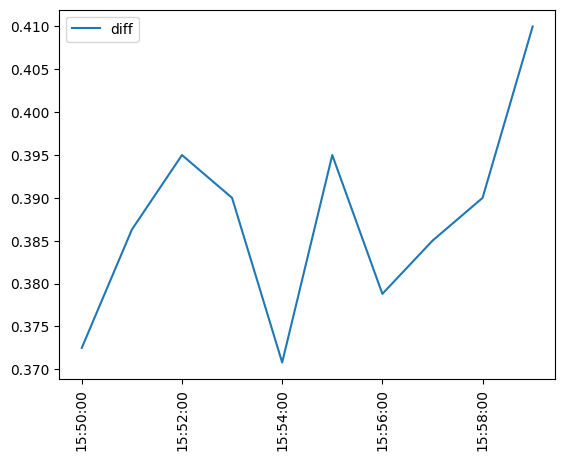

In [20]:
alphabet.iloc[-10:].plot(y = 'diff', rot = 90);

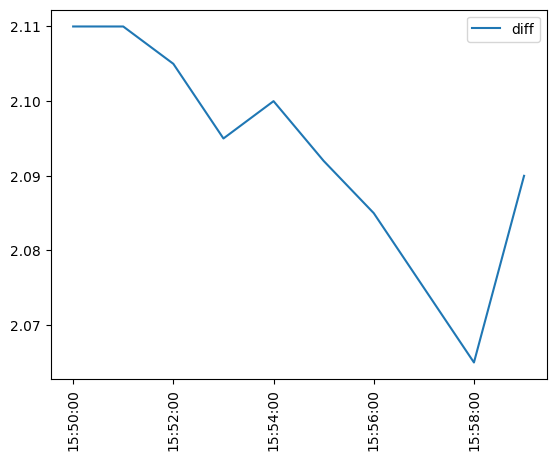

In [21]:
foxcorp.iloc[-10:].plot(y = 'diff', rot = 90);

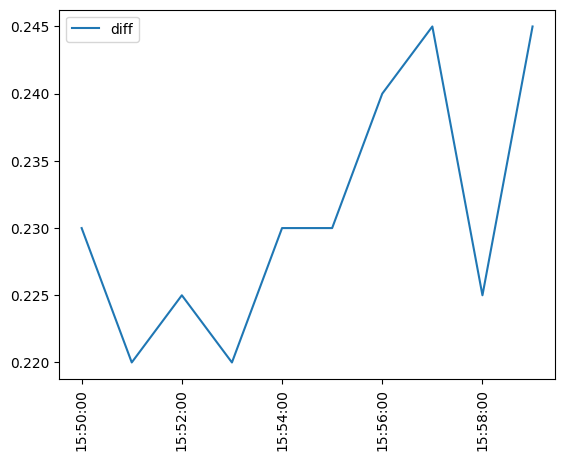

In [22]:
nwscorp.iloc[-10:].plot(y = 'diff', rot = 90);

Based on the plots, it is obvious that there are arbitrage opportunities for all three dual-listed pairs. In practicality, these dual-listed stocks can be pair-traded in order to gain profits when the arbitrage spread is greater than the transaction and brokerage costs.